### Imports

In [1]:
%matplotlib notebook  
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
from pathlib import Path

# importing model and loss function
from model.alt_loss_A import Loss
from model.models_mjp_30Jan21 import BM_ACN_1_6L as Model

# importing training utility functions
#from model.training_kde import select_gpu, Results, trainNet
from functions.new_training_kde import select_gpu, Results, trainNet
from model.plots import dual_train_plots, replace_in_ax
from model.collectdata_poca_KDE import collect_data_poca
from functions.utils import vector_to_state_dict, state_dict_to_vector

# importing modified optimizers
from functions.new_optimizers import Adam, reversible_Adam, EpochEVE 

# shows GPU usage
!nvidia-smi

Tue Sep 21 23:35:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 40%   47C    P8    25W / 250W |   9928MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

### Set up training parameters

In [2]:
# the output folder the results are stored in 
name   = 'example'

# note that baileyds is a symbolic link to a directory on share/lazy/
folder = 'baileyds/AllCNN/' + name
output = Path(folder)
output.mkdir(exist_ok=True)

n_epochs = 50
batch_size = 128 
learning_rate = 5e-5
# choose gpu to use (or cpu)
device = "cuda:2"

In [3]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

### Load data

In [4]:
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            #'/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=batch_size,
 #                           device=device,
                            masking=True,
                            shuffle=True,
                            slice = slice(None,60000)
                           )

# for EVE, need to choose a subset of the training data
EVE_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=batch_size,
 #                           device=device,
                            masking=True,
                            shuffle=True,
                           slice = slice(60000,None)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
  #                          device=device,
                            masking=True,
                            shuffle=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 17.13 s
Constructing 60000 event dataset took 0.213 s
Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 16.8 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 20.18 s
Constructing 100000 event dataset took 0.3559 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 4.949 s
Constructing 20000 event dataset took 0.07158 s


### Load model and loss function

In [5]:
model = Model()
model.to(device)

loss = Loss(epsilon=1e-5,coefficient=2.5)

### Load parameters from pretrained model if desired

In [6]:
# d_folder = 'GoodVersion_DDplus_iter0_carefulAdam_160kevents'
# suffix = '0'
# dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_folder + '_'+ suffix + '.pyt'
# print('dict_name = ',dict_name)
# pretrained_dict = torch.load(dict_name)
# model.load_state_dict(pretrained_dict,strict=False)

### Choose optimizers

In [7]:
optimizer = Adam(model.parameters(), lr=learning_rate)
ep_optimizer = EpochEVE(model.parameters(), model, loss, EVE_loader, device, steps=[0, 0.1, 0.5, 1, 2, 5])
lr_scheduler = None
careful = False
adaptive = False

### Set up plot for training

<IPython.core.display.Javascript object>


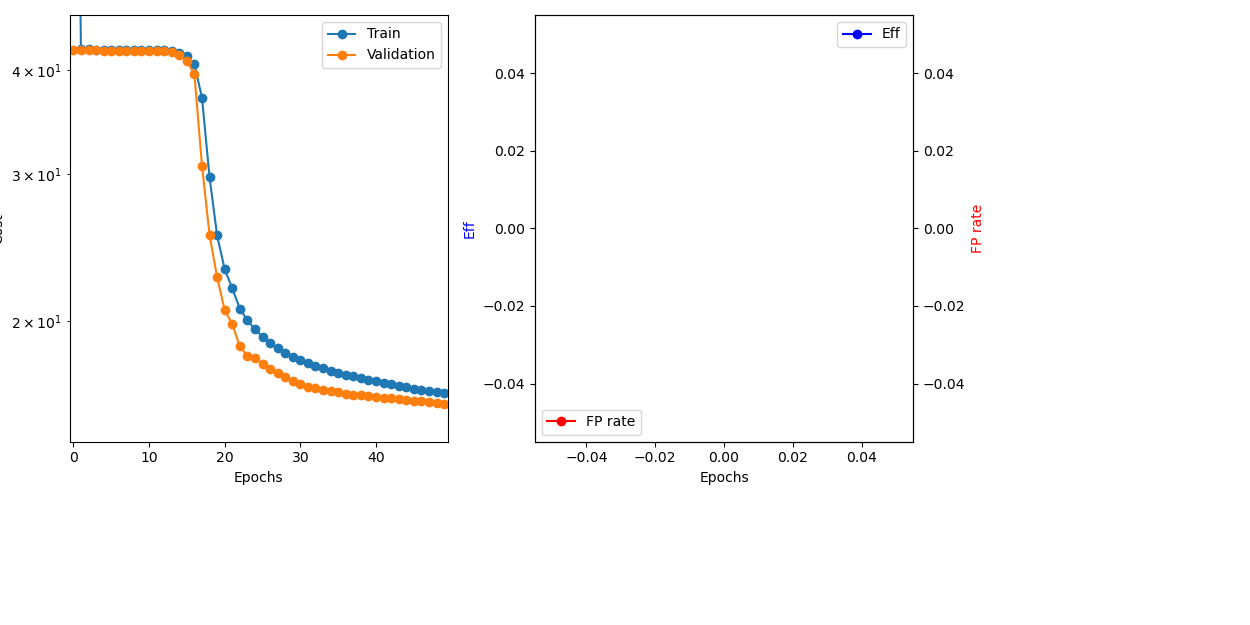

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

### Train the model

In [9]:
# save initial model state
param_states.append(get_param_state(model))
torch.save(model.state_dict(), output / f'{name}_init.pyt')

for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start = len(results),
                        notebook = True,
                        ep_optimizer = ep_optimizer,
                        lr_scheduler = lr_scheduler,
                        careful = careful,
                        adaptive = adaptive
                      ):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))
    
# save final model and stats
torch.save(model.state_dict(), output / f'{name}_final.pyt')
results.to_hdf(f'{name}_stats.hdf5', 'results')

Number of batches: train = 469, val = 157


Number of batches: train = 469, val = 157


EPOCH OPTIMIZER:
     took 44.13 s
     with step scalar: [0]
Epoch 0: train=285.38, val=42.3099, took 140.49 s


EPOCH OPTIMIZER:
     took 43.88 s
     with step scalar: [5]
Epoch 1: train=42.3718, val=42.3075, took 138.93 s


EPOCH OPTIMIZER:
     took 44.37 s
     with step scalar: [0.5]
Epoch 2: train=42.3681, val=42.3021, took 138.17 s


EPOCH OPTIMIZER:
     took 46.59 s
     with step scalar: [0.5]
Epoch 3: train=42.3594, val=42.2887, took 139.73 s


EPOCH OPTIMIZER:
     took 43.88 s
     with step scalar: [0.1]
Epoch 4: train=42.3362, val=42.2467, took 135.39 s


EPOCH OPTIMIZER:
     took 44.65 s
     with step scalar: [0.1]
Epoch 5: train=42.2927, val=42.2114, took 136.46 s


EPOCH OPTIMIZER:
     took 46.03 s
     with step scalar: [0.1]
Epoch 6: train=42.2805, val=42.2086, took 137.75 s


EPOCH OPTIMIZER:
     took 43.92 s
     with step scalar: [0.5]
Epoch 7: train=42.2785, val=42.2066, took 134.55 s


EPOCH OPTIMIZER:
     took 43.98 s
     with step scalar: [0.1]
Epoch 8: train=42.2765, val=42.2049, took 134.67 s


EPOCH OPTIMIZER:
     took 43.64 s
     with step scalar: [0]
Epoch 9: train=42.2754, val=42.2038, took 135.41 s


EPOCH OPTIMIZER:
     took 44.34 s
     with step scalar: [0]
Epoch 10: train=42.274, val=42.2025, took 135.35 s


EPOCH OPTIMIZER:
     took 46.37 s
     with step scalar: [0.5]
Epoch 11: train=42.2724, val=42.1998, took 136.47 s


EPOCH OPTIMIZER:
     took 44.10 s
     with step scalar: [0.1]
Epoch 12: train=42.2641, val=42.1833, took 134.51 s


EPOCH OPTIMIZER:
     took 43.70 s
     with step scalar: [2]
Epoch 13: train=42.2422, val=42.0886, took 134.74 s


EPOCH OPTIMIZER:
     took 44.15 s
     with step scalar: [0.1]
Epoch 14: train=42.01, val=41.7396, took 134.89 s


EPOCH OPTIMIZER:
     took 45.21 s
     with step scalar: [0.1]
Epoch 15: train=41.5523, val=41.0294, took 135.48 s


EPOCH OPTIMIZER:
     took 45.45 s
     with step scalar: [0.5]
Epoch 16: train=40.6854, val=39.5632, took 135.53 s


EPOCH OPTIMIZER:
     took 44.29 s
     with step scalar: [0.1]
Epoch 17: train=37.0593, val=30.7023, took 134.57 s


EPOCH OPTIMIZER:
     took 43.93 s
     with step scalar: [0.5]
Epoch 18: train=29.7432, val=25.3672, took 133.89 s


EPOCH OPTIMIZER:
     took 46.27 s
     with step scalar: [0.5]
Epoch 19: train=25.321, val=22.5553, took 136.58 s


EPOCH OPTIMIZER:
     took 46.56 s
     with step scalar: [0.1]
Epoch 20: train=23.0533, val=20.6005, took 137.43 s


EPOCH OPTIMIZER:
     took 44.23 s
     with step scalar: [0.5]
Epoch 21: train=21.8794, val=19.8157, took 135.13 s


EPOCH OPTIMIZER:
     took 44.87 s
     with step scalar: [0.1]
Epoch 22: train=20.6785, val=18.6293, took 135.6 s


EPOCH OPTIMIZER:
     took 45.66 s
     with step scalar: [0]
Epoch 23: train=20.0217, val=18.1427, took 135.74 s


EPOCH OPTIMIZER:
     took 44.36 s
     with step scalar: [0]
Epoch 24: train=19.5302, val=18.0499, took 133.75 s


EPOCH OPTIMIZER:
     took 45.11 s
     with step scalar: [0]
Epoch 25: train=19.1262, val=17.748, took 137.02 s


EPOCH OPTIMIZER:
     took 45.72 s
     with step scalar: [0]
Epoch 26: train=18.8163, val=17.482, took 131.92 s


EPOCH OPTIMIZER:
     took 45.59 s
     with step scalar: [0]
Epoch 27: train=18.5366, val=17.3181, took 133.27 s


EPOCH OPTIMIZER:
     took 43.54 s
     with step scalar: [0]
Epoch 28: train=18.2904, val=17.107, took 128.87 s


EPOCH OPTIMIZER:
     took 43.46 s
     with step scalar: [0]
Epoch 29: train=18.0982, val=16.9221, took 129.12 s


EPOCH OPTIMIZER:
     took 43.61 s
     with step scalar: [0]
Epoch 30: train=17.9434, val=16.8087, took 129.21 s


EPOCH OPTIMIZER:
     took 43.75 s
     with step scalar: [0]
Epoch 31: train=17.8034, val=16.6325, took 132.83 s


EPOCH OPTIMIZER:
     took 43.79 s
     with step scalar: [0]
Epoch 32: train=17.6478, val=16.61, took 136.04 s


EPOCH OPTIMIZER:
     took 43.52 s
     with step scalar: [0]
Epoch 33: train=17.5414, val=16.5032, took 136.72 s


EPOCH OPTIMIZER:
     took 44.98 s
     with step scalar: [0]
Epoch 34: train=17.4246, val=16.4567, took 136.76 s


EPOCH OPTIMIZER:
     took 43.51 s
     with step scalar: [0]
Epoch 35: train=17.3189, val=16.4047, took 137.56 s


EPOCH OPTIMIZER:
     took 43.43 s
     with step scalar: [0]
Epoch 36: train=17.2328, val=16.3235, took 136.21 s


EPOCH OPTIMIZER:
     took 43.31 s
     with step scalar: [0]
Epoch 37: train=17.1393, val=16.2918, took 133.89 s


EPOCH OPTIMIZER:
     took 46.89 s
     with step scalar: [0]
Epoch 38: train=17.0506, val=16.2641, took 140.17 s


EPOCH OPTIMIZER:
     took 46.08 s
     with step scalar: [0]
Epoch 39: train=16.9926, val=16.2316, took 140.61 s


EPOCH OPTIMIZER:
     took 44.57 s
     with step scalar: [0]
Epoch 40: train=16.9077, val=16.1808, took 138.16 s


EPOCH OPTIMIZER:
     took 45.64 s
     with step scalar: [0]
Epoch 41: train=16.8402, val=16.1373, took 141.33 s


EPOCH OPTIMIZER:
     took 44.11 s
     with step scalar: [0]
Epoch 42: train=16.771, val=16.141, took 137.4 s


EPOCH OPTIMIZER:
     took 46.59 s
     with step scalar: [0]
Epoch 43: train=16.7039, val=16.1086, took 137.27 s


EPOCH OPTIMIZER:
     took 44.36 s
     with step scalar: [0]
Epoch 44: train=16.6401, val=16.0527, took 135.61 s


EPOCH OPTIMIZER:
     took 45.71 s
     with step scalar: [0]
Epoch 45: train=16.5726, val=16.0341, took 135.09 s


EPOCH OPTIMIZER:
     took 43.85 s
     with step scalar: [0]
Epoch 46: train=16.5268, val=16.0175, took 136.03 s


EPOCH OPTIMIZER:
     took 43.23 s
     with step scalar: [0]
Epoch 47: train=16.4674, val=15.9787, took 131.15 s


EPOCH OPTIMIZER:
     took 43.26 s
     with step scalar: [0]
Epoch 48: train=16.4088, val=15.9311, took 130.17 s


EPOCH OPTIMIZER:
     took 46.27 s
     with step scalar: [0]
Epoch 49: train=16.3574, val=15.8981, took 132.66 s



Save the plot above:

<IPython.core.display.Javascript object>


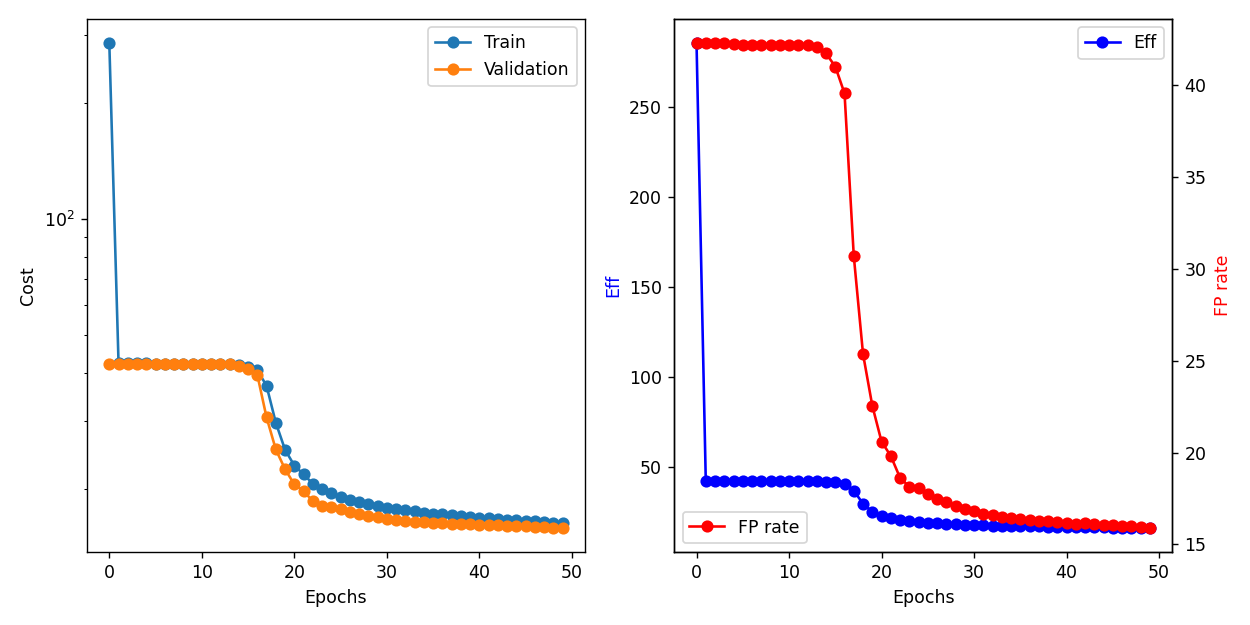

In [14]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

### Plotting the angle grid and step sizes

In [12]:
# getting angles between steps
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 30
num_epochs = n_epochs

ep_intervals = [(np.arange(0, num_epochs+1, grid_size)[i], np.arange(0, num_epochs+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)
    
    
# getting sizes of steps
step_sizes = []
for i in range(num_epochs-1):
    step_sizes.append(np.linalg.norm(param_states[i+1]-param_states[i]))

<IPython.core.display.Javascript object>


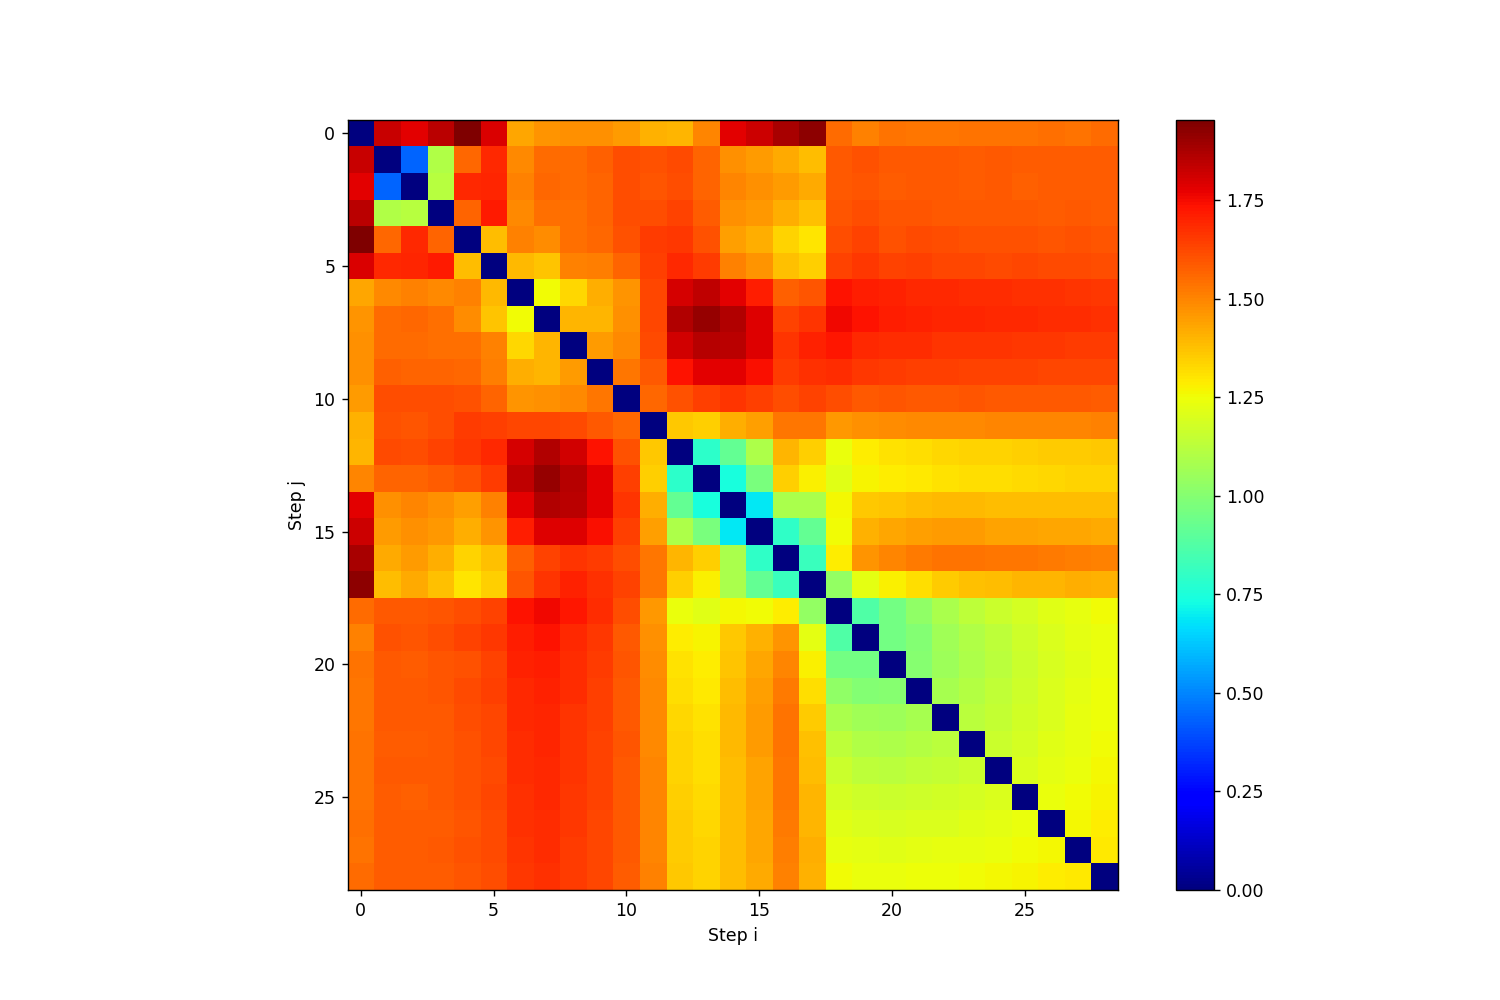

<IPython.core.display.Javascript object>


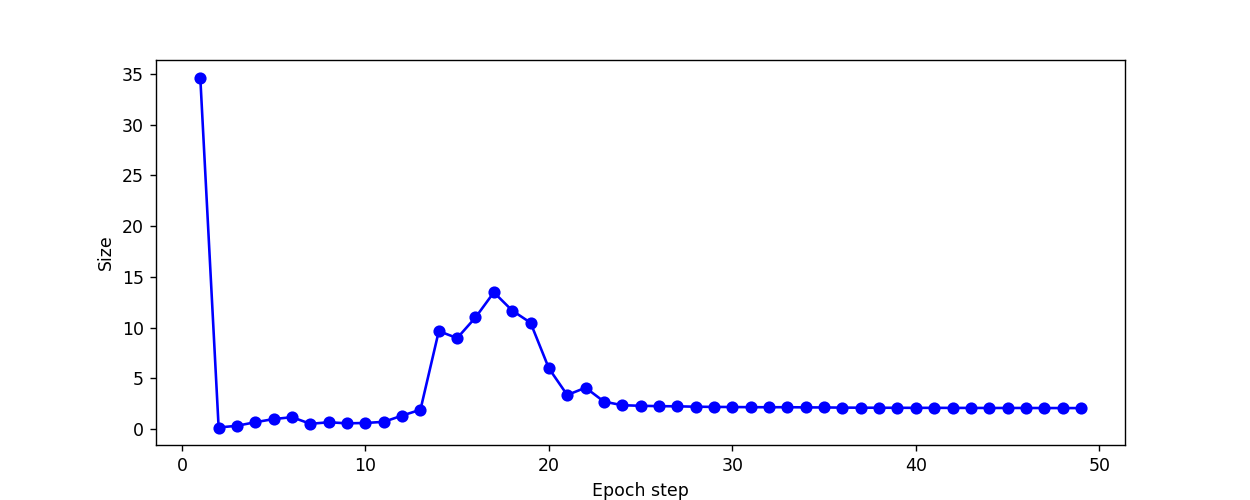

Text(0, 0.5, 'Size')

In [13]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
plt.figure()
plt.plot(np.arange(1, num_epochs), step_sizes, 'bo-')
plt.xlabel('Epoch step')
plt.ylabel('Size')